# Live Bicep Curl Checker using Heuristic Model 

Live realtime analysis by heuristic technique.

Bicep curl instructions: Stand side on with left-side facing towards the camera. Make sure elbows and shoulders remain placed during the exercise and remain upright. Maximise the contraction in the bicep and avoid using momentum. 

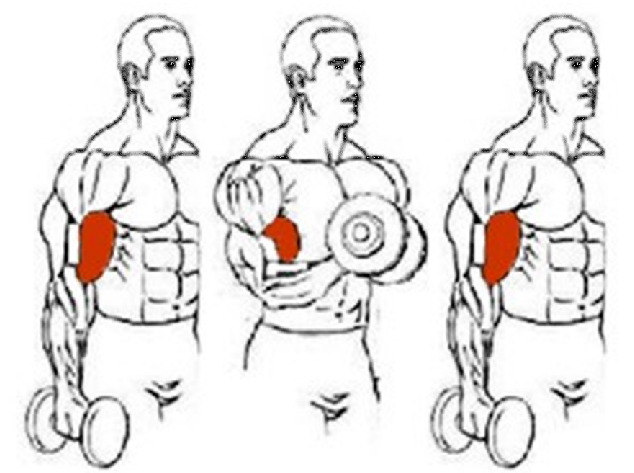
Neves, Eduardo & Alves, José & Krueger, Eddy & Reis, Victor. (2014). Changes in Skin Temperature During Muscular Work: A Pilot Study. Pan American Journal of Medical Thermology. 1. 11-15. 10.18073/2358-4696/pajmt.v1n1p11-15.

## TOC:
0. [Setup](#0.-Import-Libraries-&-Setup)
1. [Draw Angles](#1.-Draw-Angles-&-Display)

# 0. Import Libraries & Setup

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import math

In [2]:
def get_angle(x1, y1, x2, y2, x3, y3):
    a = np.array([x1, y1]) # First
    b = np.array([x2, y2]) # Mid
    c = np.array([x3, y3]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# 1. Draw Angles & Display

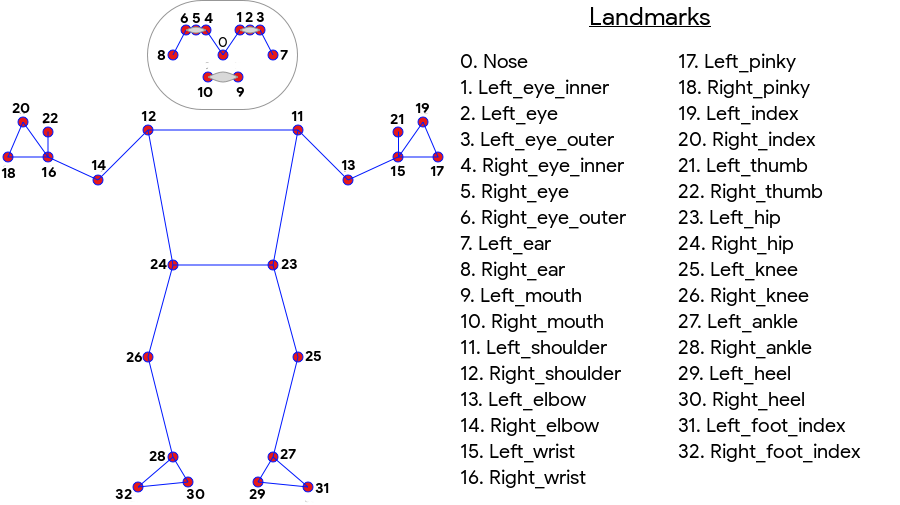

In [3]:
# The colours to display the angles we want to visualise
colours = []
colours.append((128, 0, 250)) # Pink
colours.append((255,255,0)) # Blue

angles = {}
# Tuples (keypoint_1, keypoint_2, keypoint_3) that we want to visualise
# The heurstic model checks the elbow-hip angle and the hip angle
angles['elbow_hip'] = (13, 11, 23) # Elbow-hip angle
angles['hip'] = (11, 23, 25) # Hip angle

if len(angles) > len(colours):
    raise ValueError('The colours array should be longer or the same length as the angles array. Please add some more colours')

In the heuristic model, if the elbow-hip angle exceeds 45 degrees then it will be flagged that the elbow is flared out. If the hip angle is below 160 degrees then it will be flagged that the shoulder is being used for momentum.

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture(0)
with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

    while cap.isOpened():
        ret, image = cap.read()
        
        height, width, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        if results.pose_landmarks != None:
            output = None
            first = True
            i=0
            display_msg = 'Good so far, keep it up'
            
            for name, a in angles.items():
                # Get the angle value
                x1 = int(results.pose_landmarks.landmark[a[0]].x * width)
                y1 = int(results.pose_landmarks.landmark[a[0]].y * height)

                x2 = int(results.pose_landmarks.landmark[a[1]].x * width)
                y2 = int(results.pose_landmarks.landmark[a[1]].y * height)

                x3 = int(results.pose_landmarks.landmark[a[2]].x * width)
                y3 = int(results.pose_landmarks.landmark[a[2]].y * height)

                angle = get_angle(x1, y1, x2, y2, x3, y3)
                
                # Draw the angle on a new frame
                aux_image = np.zeros(image.shape, np.uint8)
                cv2.line(aux_image, (x1, y1), (x2, y2), (255, 255, 0), 20)
                cv2.line(aux_image, (x2, y2), (x3, y3), (255, 255, 0), 20)
                cv2.line(aux_image, (x1, y1), (x3, y3), (255, 255, 0), 5)
                contours = np.array([[x1, y1], [x2, y2], [x3, y3]])
                cv2.fillPoly(aux_image, pts=[contours], color=colours[i])

                # Stack frames on top of each other
                if first:
                    output = cv2.addWeighted(image, 1, aux_image, 0.8, 0)
                    first = False
                else:
                    output = cv2.addWeighted(output, 1, aux_image, 0.8, 0)
                
                # Draw the keypoints and angle value on the frame
                cv2.circle(output, (x1, y1), 6, (0, 255, 255), 4)
                cv2.circle(output, (x2, y2), 6, (128, 0, 250), 4)
                cv2.circle(output, (x3, y3), 6, (255, 191, 0), 4)
                cv2.putText(output, str(int(angle)), (x2 + 30, y2), 1, 1.5, colours[i], 2)
                i+=1
                
                # Set the display message
                if name == 'elbow_hip' and (angle > 45):
                    display_msg = 'Keep your elbows tucked in'
                elif name == 'hip' and (angle < 160):
                    display_msg = 'Stop using your shoulder for momentum'
                    
                cv2.rectangle(output, (0, 0), (900, 60), (0, 0, 0), -1)
                cv2.putText(output, display_msg, (0,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
                cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
                cv2.imshow('output', output)
        else:
            display_msg = 'Skeleton not detected in frame'
            cv2.rectangle(image, (0, 0), (900, 60), (0, 0, 0), -1)
            cv2.putText(image, display_msg, (0,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
            cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
            cv2.imshow('output', image)
        
        # Press ESC to exit
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()